In [1]:
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 874.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 4.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 93.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 63.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 14.9 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=ae1edf20da8ae4918e358f31fc76fd475d90f70

In [12]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [13]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')



class CCSSE:
    def __init__(self, dataset, samples = None, K = 5, generation = 10):
        self.dataset = dataset
        self.samples = samples
        self.K = K
        self.generation = generation
        
        self.x_train, self.x_test, self.y_train, self.y_test, self.dfx_full, self.dfy_full = self.get_datasets_train_test()

        self.bb_model, self.p = self.get_bb_model()
        self.explainerCSSE = self.get_model_contrafactual()
        self.model_causal, self.df_causal_effects, self.df_error, self.causal_order = self.get_model_causality()
    
        self.run_dict = {}
        self.run_non_causal_dict = {}
    
    def get_datasets_train_test(self):
        if self.dataset == "german_short":
            map_columns = {
                'Unnamed: 0': 'index',
                'x0': 'Sex',
                'x1': 'Age',
                'x2': 'Credit',
                'x3': 'LoanDuration',
            }
            x_train = pd.read_csv("data/algrec_german/X_train_short.csv").rename(columns = map_columns)
            x_test = pd.read_csv("data/algrec_german/X_test_short.csv").rename(columns = map_columns)
            y_train = pd.read_csv("data/algrec_german/y_train_short.csv").rename(columns={'Unnamed: 0': 'index'})
            y_test = pd.read_csv("data/algrec_german/y_test_short.csv").rename(columns={'Unnamed: 0': 'index'})
            x_train = x_train.set_index('index')
            x_test = x_test.set_index('index')
            y_train = y_train.set_index('index')
            y_test = y_test.set_index('index')
            dfx_full = pd.concat([x_train, x_test])
            dfy_full = pd.concat([y_train, y_test])

        elif self.dataset == "german_medium":
            map_columns = {
                'Unnamed: 0': 'index',
                'x0': 'Sex',
                'x1': 'Age',
                'x2': 'Credit',
                'x3': 'LoanDuration',
                'x4': 'CheckingAccountBalance',
                'x5':'SavingsAccountBalance',
                'x6':'HousingStatus'
            }
            x_train = pd.read_csv("data/algrec_german/X_train.csv").rename(columns = map_columns)
            x_test = pd.read_csv("data/algrec_german/X_train.csv").rename(columns = map_columns)
            y_train = pd.read_csv("data/algrec_german/X_train.csv").rename(columns={'Unnamed: 0': 'index'})
            y_test = pd.read_csv("data/algrec_german/X_train.csv").rename(columns={'Unnamed: 0': 'index'})
            x_train = x_train.set_index('index')
            x_test = x_test.set_index('index')
            y_train = y_train.set_index('index')
            y_test = y_test.set_index('index')
            dfx_full = pd.concat([x_train, x_test])
            dfy_full = pd.concat([y_train, y_test])

        elif self.dataset == "german_full":
            df_main = prepare_german_dataset("german_credit.csv", "data/")
            columns = df_main.columns
            class_name = 'default' # default = 0 = "Good class" / default = 1 = "Bad class" 
            columns_tmp = list(columns)
            columns_tmp.remove(class_name)

            x_train, x_test, y_train, y_test = train_test_split(df_main[columns_tmp], df_main[class_name], test_size=0.1)

            dfx_full = pd.concat([x_train, x_test])
            dfy_full = pd.concat([y_train, y_test])

        else:
            x_train = pd.DataFrame()
            x_test = pd.DataFrame()
            y_train = pd.DataFrame()
            y_test = pd.DataFrame()
            dfx_full = pd.DataFrame()
            dfy_full = pd.DataFrame()

        return x_train, x_test, y_train, y_test, dfx_full, dfy_full
    

    def get_bb_model(self):
        bb_model = RandomForestClassifier(n_estimators = 120, n_jobs=-1, random_state=0)  
        bb_model.fit(self.x_train, self.y_train)

        p = bb_model.predict(self.x_test)

        print(classification_report(self.y_test, p))

        return bb_model, p

    def get_model_contrafactual(self):
        return CSSE(self.dfx_full, self.bb_model, K = self.K, num_gen = self.generation)

    def get_model_causality(self):
        model_causal = lingam.DirectLiNGAM()
        model_causal.fit(self.dfx_full)
            
        labels = [f'{i}' for i in self.dfx_full.columns]
        causal_order = [labels[x] for x in model_causal.causal_order_]
        
        matrix = model_causal.adjacency_matrix_
        from_list = []
        to_list = []
        effect_list = []

        # Iteração sobre a matriz para extrair os valores e suas posições
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    from_list.append(j)
                    to_list.append(i)
                    effect_list.append(matrix[i][j])

        # Criando o DataFrame
        df_causal_effects = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
        labels = [f'{i}' for i in self.dfx_full.columns]
        df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
        df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])


        matrix_error = model_causal.get_error_independence_p_values(self.dfx_full)
        from_list = []
        to_list = []
        effect_list = []

        # Iteração sobre a matriz para extrair os valores e suas posições
        for i in range(len(matrix_error)):
            for j in range(i + 1, len(matrix_error[i])):
                if matrix_error[i][j] != 0:
                    from_list.append(j)
                    to_list.append(i)
                    effect_list.append(matrix_error[i][j])

        # Criando o DataFrame
        df_error = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
        labels = [f'{i}' for i in self.dfx_full.columns]
        df_error['from'] = df_error['from'].apply(lambda x : labels[x])
        df_error['to'] = df_error['to'].apply(lambda x : labels[x])
        

        return model_causal, df_causal_effects, df_error, causal_order
        
    
    def print_causal_graph(self):
        make_dot(self.model_causal.adjacency_matrix_)

    def run_non_causal(self):
        self.run_non_causal_dict = {}

        if isinstance(self.samples, list):
            self.create_run_dict(self)
            for sample in self.samples:
                self.run_non_causal_sample(sample)
                
        elif isinstance(self.samples, int):
            for sample in range(self.samples):
                self.run_non_causal_sample(sample)
        
        else: 
            for sample in range(10):
                self.run_non_causal_sample(sample)
                
    def run_non_causal_sample(self, sample):
        self.run_non_causal_dict[sample] = {}
        original_instance = self.x_test.iloc[sample].copy()
        contrafactual_set, solution = self.explainerCSSE.explain(original_instance, self.p[sample]) #Method returns the list of counterfactuals and the explanations generated from them

        self.run_non_causal_dict[sample]['solution'] = solution

    def run_causal(self):
        self.run_dict = {}
        self.run_dict['global_numbers'] = {
                    "global_quant_changes": 0,
                    "global_quant_causal_changes": 0,
                    "global_quant_causal_rules": 0,
                    "global_quant_zeros_causal": 0,
                    "global_quant_full_causal": 0,
                    "global_quant_causal_contrafac": 0,
                    "global_quant_maioria_causal_satisfeita": 0,
                    "global_quant_contrafac_unico": 0
            }
        self.global_quant_contrafac_max = 0
        if isinstance(self.samples, list):
            self.create_run_dict(self)
            for sample in self.samples:
                self.run_causal_sample(sample)
                
        elif isinstance(self.samples, int):
            for sample in range(self.samples):
                self.run_causal_sample(sample)
        
        else: 
            for sample in range(10):
                self.run_causal_sample(sample)
        
        self.global_quant_contrafac_max = self.K * len(self.run_dict)


    def run_causal_sample(self, sample):
        original_instance = self.x_test.iloc[sample]
        self.run_dict[sample] = {}
        self.run_dict[sample]['original_instance'] = original_instance

        print(f'Running original instance:\n {display(original_instance)}')

        causal_explain = self.get_causal_explain(sample)
        self.run_dict[sample]['causal_explain'] = causal_explain

        list_analyse = []
        for contrafactual in causal_explain[0]:
            list_analyse.append(self.analyse_contrafac(contrafactual, causal_explain[1], causal_explain[2]))

        self.run_dict[sample]['list_analyse'] = list_analyse
        self.analyse_explaination(sample)

    def analyse_contrafac(self, contrafac, df, original_ind):
        columns = [x.column for x in contrafac]
        condicao = (df['to'].isin(columns)) & (df['from'].isin(columns))
        ind = original_ind[columns]
        return [contrafac, df[condicao], ind]

    def get_causal_explain(self, sample):
        original_ind = self.x_test.iloc[sample].copy() #Original instance
        #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
        self.explainerCSSE.current_class = self.p[sample] #Original instance class
        self.explainerCSSE.original_ind = original_ind
        
        ind_cur_class = self.explainerCSSE.getBadClass()

        #Gets the valid values range of each feature
        features_range = []
        features_range = self.explainerCSSE.getFeaturesRange()

        #The DataFrame df will have the current population
        df = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)

        #Generates the initial population with popinitial mutants        
        self.explainerCSSE.getPopInicial(df, features_range)
        df_causal = df.copy()
        dict_dfs = {}

        # for g in tqdm(range(self.explainerCSSE.num_gen), desc= "Processing..."):
        for g in tqdm(range(self.generation), desc= "Processing..."):

            #To use on the parents of each generation
            old_parents = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)

            #Copy parents to the next generation
            old_parents = df_causal.copy()
            dict_dfs[g] = {}

            parents_causal = self.apply_causality(old_parents)
            dict_dfs[g]['causal_parents'] = parents_causal
            #df will contain the new population
            df_causal = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)
            evaluation_causal = []

            #Assessing generation counterfactuals
            self.explainerCSSE.fitness(dict_dfs[g]['causal_parents'], evaluation_causal, ind_cur_class)

            #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
            df_causal.loc[0] = original_ind.copy()

            #Copies to the next generation the per_elit best individuals
            self.explainerCSSE.elitism(evaluation_causal, df_causal, parents_causal)
            number_cross_repetitions = 0
            while len(df_causal) < self.explainerCSSE.pop_size + 1: #+1, as the 1st position is used to store the reference individual
                number_cross_repetitions_causal = self.explainerCSSE.crossover(df_causal, parents_causal, evaluation_causal, number_cross_repetitions)

                mutation_op = rnd.random()
                if mutation_op <= self.explainerCSSE.mutation_proba:
                    self.explainerCSSE.mutation(df_causal, len(df_causal) - 1, features_range)


        evaluation = []
        evaluation_causal = []

        #Evaluating the latest generation
        self.explainerCSSE.fitness(df_causal, evaluation_causal, ind_cur_class)

        #Order the last generation by distance to the original instance     
        evaluation_causal.sort(key=lambda individual: individual.aval_norm) 

        #Getting the counterfactual CAUSAL set
        contrafactual_set_causal, solution_list_causal = self.explainerCSSE.getContrafactual(df_causal, evaluation_causal) 

        dict_dfs['contrafactual_set_causal'] = contrafactual_set_causal
        dict_dfs['solution_list_causal'] = solution_list_causal
        
        df_contrafac_causal = self.get_contrafac_df_causal(solution_list_causal)
        return [solution_list_causal, df_contrafac_causal, original_ind]
    

    def apply_causality(self, df):
        df_apply_causal = pd.DataFrame(columns = df.columns)
        original = df.iloc[0]
        df_apply_causal.loc[0] = original
        for index, df_row in df.iloc[1:].iterrows():
            causal_ind = df_row.copy()
            for column in self.causal_order:
                value_diff = causal_ind[column] - original[column]
                if value_diff != 0:
                    tmp_effects = self.df_causal_effects[self.df_causal_effects['from'] == column]
                    for index, row in tmp_effects.iterrows():
    #                     prob = rnd.random()
    #                     if row['probability'] <= prob:
                        tmp_error = self.df_error[self.df_error['from'].isin([column, row['to']]) | self.df_error['to'].isin([column, row['to']])]
                        error_value = tmp_error['effect'].iloc[0]
    #                     print(f'error value = {error_value}')
                        causal_ind[row['to']] = causal_ind[row['to']] + (value_diff * row['effect']) + tmp_error['effect'].iloc[0]
            df_apply_causal.loc[len(df_apply_causal)] = causal_ind
        return df_apply_causal


    def get_contrafac_df_causal(self, solution_list_causal):
        lista_solution_causal = [[t.column for t in sublist] for sublist in solution_list_causal]

        # Inicializa uma lista para armazenar os resultados
        resultados = []

        # Loop sobre os valores na lista
        for lista_valores in lista_solution_causal:
            if len(lista_valores) > 1:
                for v1 in lista_valores:
                    for v2 in lista_valores:
                        if v1 != v2:
                            # Cria uma condição para cada par de valores diferentes na lista
                            condicao = (self.df_causal_effects['to'].isin([v1, v2])) & (self.df_causal_effects['from'].isin([v1, v2]))
                            # Realiza a busca no DataFrame usando a condição e armazena os resultados
                            resultados.append(self.df_causal_effects[condicao])

        # Concatena os resultados em um único DataFrame
        if resultados:
            resultado_final = pd.concat(resultados)
            resultado_final = resultado_final.drop_duplicates()
        else:
            resultado_final = pd.DataFrame(columns = self.df_causal_effects.columns)
            
        return resultado_final
    

    def analyse_explaination(self, sample):
        self.run_dict[sample]['data_analysis'] = []
        for i, content in enumerate(self.run_dict[sample]['list_analyse']):
            self.global_quant_contrafac_max += 1
            controle = {}
            causal = content[0]
            df = content[1]
            ori = content[2]
            
            
            num_changes = len(causal)
            self.run_dict['global_numbers']['global_quant_changes'] += num_changes
            
            num_causal_rules = len(df)
            self.run_dict['global_numbers']['global_quant_causal_rules'] += num_causal_rules
            
            for attr in causal:
                key = attr.column
                if attr.value > ori[key]:
                    controle[key] = 'mais'
                else:
                    controle[key] = 'menos'

            df_temp = df.copy()
            df_temp['from'] = df['from'].map(controle)
            df_temp['to'] = df['to'].map(controle)
            df_temp['causal'] = df_temp.apply(self.verificar_condicoes, axis = 1)
            data_dict = {}

            data_dict['df_respeita_causal'] = df_temp
            data_dict['contrafactual_causal'] = causal
            data_dict['df_causal_effects'] = df
            
            self.run_dict[sample]['data_analysis'].append(data_dict)


            causal_finds = df_temp['causal'].sum()
            self.run_dict['global_numbers']['global_quant_causal_changes'] += causal_finds
            
            # print(f'causal = \n{causal}\n')
            # print(f'original = \n{ori}\n')
            # print(f'df_temp = \n{display(df_temp)}\n')
            
            if len(df_temp) > 0:
                if causal_finds > 0:
                    self.run_dict['global_numbers']['global_quant_causal_contrafac'] += 1
                else:
                    # print(f'nenhuma relaçao causal satisfeita')
                    self.run_dict['global_numbers']['global_quant_zeros_causal'] += 1
    #                 display(df_temp)
    #                 print(f"original = {ori}")
    #                 print(f"causal = {causal}")

                if causal_finds == num_causal_rules:
                    self.run_dict['global_numbers']['global_quant_full_causal'] += 1
                    # if causal_finds > 2:
                        # print(f'todas > 2 relaçoes causais satisfeitas')
    #                     display(df_temp)
    #                     print(f"original = {ori}")
    #                     print(f"causal = {causal}")
                    # elif causal_finds == 1:
                        # print(f'todas = 1 relaçoes causais satisfeitas')
                
                if causal_finds >= (len(df_temp)/2):
                    self.run_dict['global_numbers']['global_quant_maioria_causal_satisfeita'] += 1
            else:
    #             if len(causal) > 0:
                self.run_dict['global_numbers']['global_quant_contrafac_unico'] += 1
        
    def verificar_condicoes(self, row):
        if (row['from'] == 'mais' and row['to'] == 'mais' and row['effect'] > 0):
            return True
        elif row['from'] == 'menos' and row['to'] == 'menos' and row['effect'] > 0:
            return True
        elif row['from'] == 'mais' and row['to'] == 'menos' and row['effect'] < 0:
            return True
        elif row['from'] == 'menos' and row['to'] == 'mais' and row['effect'] < 0:
            return True
        else:
            return False
            

    def show_metrics(self):
        
        print(f"quantas instancias contrafactuais encontradas = {self.global_quant_contrafac_max}")
        print(f"quantidade de mudanças totais = {self.run_dict['global_numbers']['global_quant_changes']}")

        print(f"quantas instancias tiveram pelo menos uma relação causal satisfeita = {self.run_dict['global_numbers']['global_quant_causal_contrafac']}/{self.global_quant_contrafac_max}")

        print(f"quantas relações causais foram encontradas = {self.run_dict['global_numbers']['global_quant_causal_rules']}")

        print(f"quantas relações causais foram satisfeitas = {self.run_dict['global_numbers']['global_quant_causal_changes']}/{self.run_dict['global_numbers']['global_quant_causal_rules']}")

        print(f"quantas instâncias não tiveram nenhuma relação causal satisfeita = {self.run_dict['global_numbers']['global_quant_zeros_causal']}/{self.global_quant_contrafac_max}")
        print(f"quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = {self.run_dict['global_numbers']['global_quant_full_causal']}/{self.run_dict['global_numbers']['global_quant_causal_contrafac']}")

        print(f"quantas instancias causais teveram a maioria das relacoes causais satisfeitas = {self.run_dict['global_numbers']['global_quant_maioria_causal_satisfeita']}/{self.global_quant_contrafac_max}")
        print(f"quantas instancias tiveram um unico atributo modificado = {self.run_dict['global_numbers']['global_quant_contrafac_unico']}/{self.global_quant_contrafac_max}")
        print('---------------------------------------------------------------------------------------')

        

In [14]:
ccsse = CCSSE('german_short', samples = 20, K = 10, generation= 10)

              precision    recall  f1-score   support

         0.0       0.43      0.58      0.49        66
         1.0       0.54      0.39      0.46        84

    accuracy                           0.47       150
   macro avg       0.48      0.48      0.47       150
weighted avg       0.49      0.47      0.47       150



In [15]:
ccsse.run_causal()

Sex                0.0
Age               37.0
Credit          1274.0
LoanDuration      12.0
Name: 747, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Sex                1.0
Age               32.0
Credit          1136.0
LoanDuration       9.0
Name: 349, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Sex                1.0
Age               25.0
Credit          1264.0
LoanDuration      15.0
Name: 979, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Sex               1.0
Age              46.0
Credit          697.0
LoanDuration     12.0
Name: 925, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Sex                1.0
Age               35.0
Credit          7253.0
LoanDuration      33.0
Name: 411, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Sex                1.0
Age               43.0
Credit          2442.0
LoanDuration      27.0
Name: 890, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Sex                1.0
Age               32.0
Credit          4583.0
LoanDuration      30.0
Name: 646, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


Sex               1.0
Age              41.0
Credit          719.0
LoanDuration     12.0
Name: 443, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Sex                1.0
Age               34.0
Credit          3965.0
LoanDuration      42.0
Name: 76, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Sex                1.0
Age               27.0
Credit          2613.0
LoanDuration      36.0
Name: 225, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Sex                0.0
Age               35.0
Credit          1291.0
LoanDuration      12.0
Name: 238, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


Sex                1.0
Age               36.0
Credit          4241.0
LoanDuration      24.0
Name: 597, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


Sex                1.0
Age               46.0
Credit          2611.0
LoanDuration      24.0
Name: 839, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


Sex                1.0
Age               32.0
Credit          1938.0
LoanDuration      24.0
Name: 321, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Sex                1.0
Age               31.0
Credit          3621.0
LoanDuration      24.0
Name: 949, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Sex                0.0
Age               32.0
Credit          2528.0
LoanDuration      27.0
Name: 704, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Sex                1.0
Age               60.0
Credit          2246.0
LoanDuration      12.0
Name: 589, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Sex                0.0
Age               67.0
Credit          3872.0
LoanDuration      18.0
Name: 779, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Sex                0.0
Age               21.0
Credit          3441.0
LoanDuration      30.0
Name: 618, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Sex               1.0
Age              20.0
Credit          674.0
LoanDuration     12.0
Name: 188, dtype: float64

Running original instance:
 None


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


In [16]:
ccsse.show_metrics()

quantas instancias contrafactuais encontradas = 210
quantidade de mudanças totais = 77
quantas instancias tiveram pelo menos uma relação causal satisfeita = 9/210
quantas relações causais foram encontradas = 12
quantas relações causais foram satisfeitas = 10.0/12
quantas instâncias não tiveram nenhuma relação causal satisfeita = 2/210
quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = 9/9
quantas instancias causais teveram a maioria das relacoes causais satisfeitas = 9/210
quantas instancias tiveram um unico atributo modificado = 43/210
---------------------------------------------------------------------------------------


In [8]:
ccsse.df_causal_effects

,from,to,effect
0,Sex,Age,5.592995
1,LoanDuration,Credit,142.214200


In [11]:
ccsse.run_dict[0]['list_analyse']

[[[('Credit', 757.8730396979657)],
  Empty DataFrame
  Columns: [from, to, effect]
  Index: [],
  Credit    1274.0
  Name: 747, dtype: float64],
 [[('Age', 43.09)],
  Empty DataFrame
  Columns: [from, to, effect]
  Index: [],
  Age    37.0
  Name: 747, dtype: float64]]

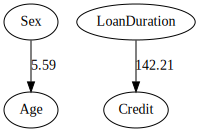

In [17]:
make_dot(ccsse.model_causal.adjacency_matrix_, labels = ccsse.dfx_full.columns.to_list())

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Dados da tabela LaTeX
data = {
    "Categoria": ["Número de instâncias contrafactuais",
                  "Número de atributos modificados",
                  "Número de instâncias contrafactuais causais",
                  "Número de relações causais analisadas",
                  "Número de relações causais satisfeitas",
                  "Número de instâncias contrafactuais com um único atributo modificado"],
    "German_Short": [210, 77, 52, 12, 10, 43],
    "German_Full": [210, 634, 70, 1288, 1013, 6]
}

# Convertendo em DataFrame
df = pd.DataFrame(data)

df


,Categoria,German_Short,German_Full
0,Número de instâncias contrafactuais,210,210
1,Número de atributos modificados,77,634
2,Número de instâncias contrafactuais causais,52,70
3,Número de relações causais analisadas,12,1288
4,Número de relações causais satisfeitas,10,1013
5,Número de instâncias contrafactuais com um úni...,43,6


TypeError: no numeric data to plot

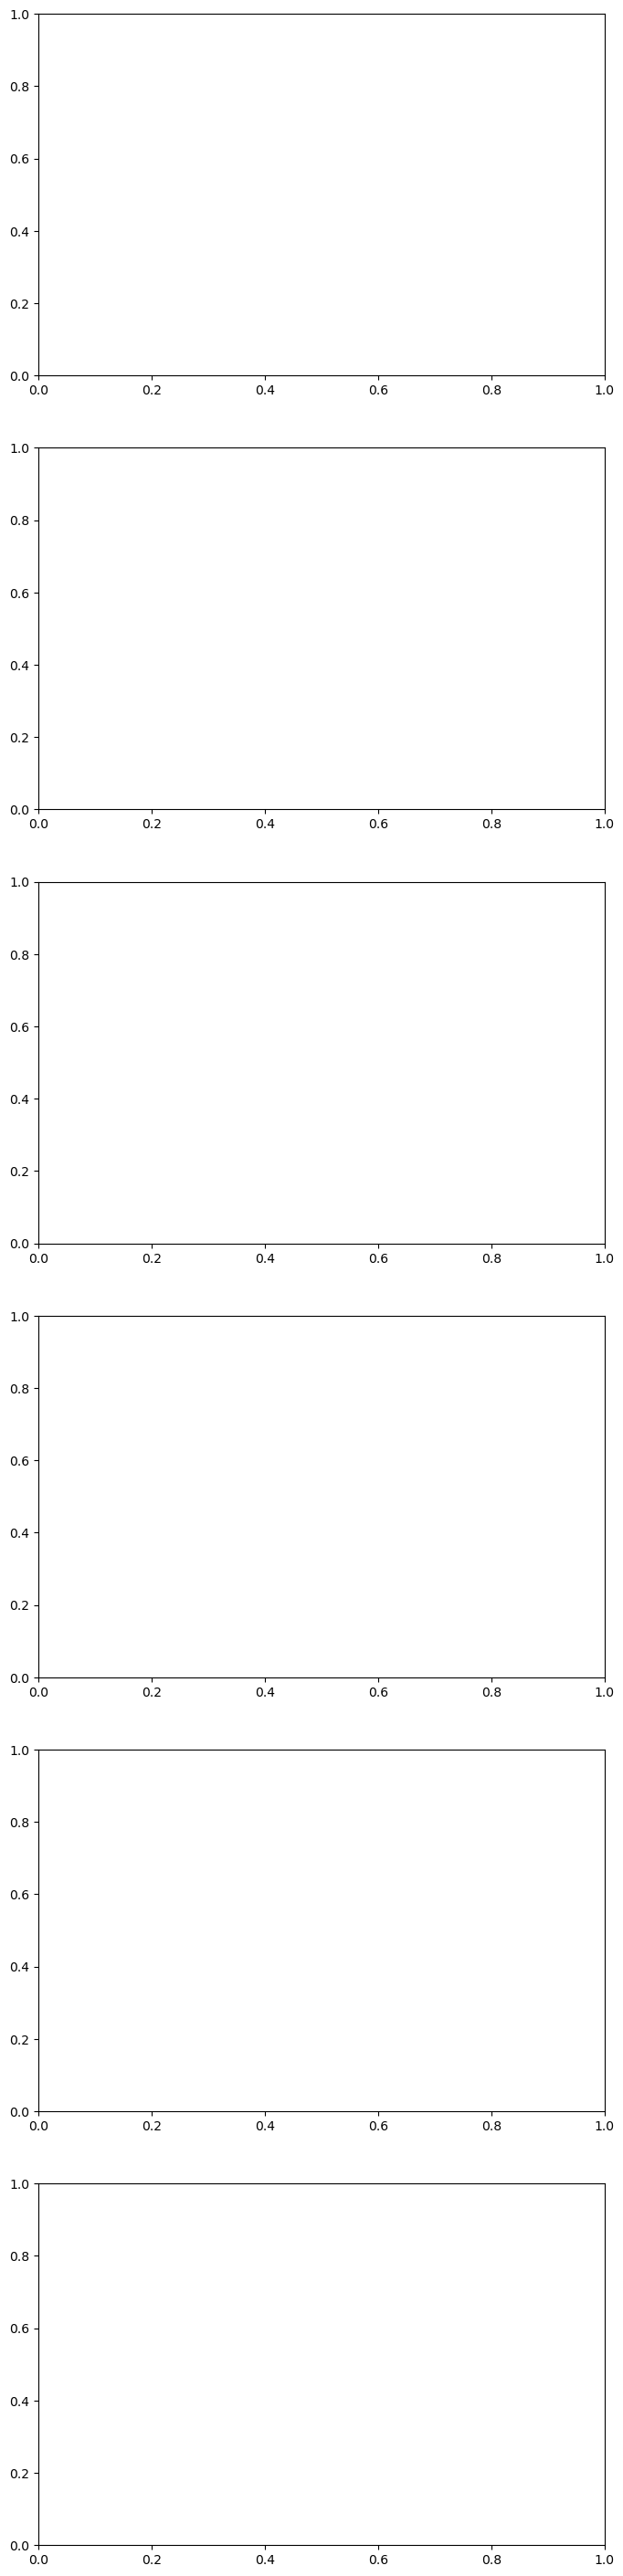

In [20]:
# Plotando gráficos de barras
fig, axes = plt.subplots(nrows=len(df), ncols=1, figsize=(8, 6 * len(df)))

for i, (index, row) in enumerate(df.iterrows()):
    ax = axes[i]
    row.plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen'])
    ax.set_ylabel(df.columns[i])
    ax.set_xticklabels([index], rotation=45)

plt.tight_layout()
plt.show()